<H1> Heart Disease prediction for early detection

<H2>Data Loading and Environment Setup</H2>

Link- https://www.kaggle.com/datasets/neurocipher/heartdisease

In [291]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [233]:
import zipfile
zip_path = "archive.zip"
extract_path = "archive"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir("archive"))

['Heart_Disease_Prediction.csv']


In [234]:
df= pd.read_csv("archive/Heart_Disease_Prediction.csv")
print(df.head())

   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  
2                        0   

<H2>EDA</H2>

In [235]:
df.shape

(270, 14)

In [236]:
df.sample(5)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
144,54,1,2,192,283,0,2,195,0,0.0,1,1,7,Presence
135,46,0,3,142,177,0,2,160,1,1.4,3,0,3,Absence
69,47,1,3,108,243,0,0,152,0,0.0,1,0,3,Presence
249,60,1,4,145,282,0,2,142,1,2.8,2,2,7,Presence
227,43,0,4,132,341,1,2,136,1,3.0,2,0,7,Presence


In [237]:
df.info()  #info finding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [238]:
df.isnull().sum() #Finding missing values

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [239]:
df.describe()  #statistics finding

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


In [240]:
df.duplicated().sum()  #Finding if there is any duplicated value

np.int64(0)

In [241]:
df["Heart Disease"] = df["Heart Disease"].replace({
    "Presence": 1,
    "Absence":0
})                   #Encoding heart disease catagorical data with numerical data for analysis

/var/folders/7j/51kz1ggn0yz0k_yn80ljvqtc0000gn/T/ipykernel_8788/934473404.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Heart Disease"] = df["Heart Disease"].replace({


In [242]:
df

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


<H2>Univariate analysis</H2>

<Axes: ylabel='count'>

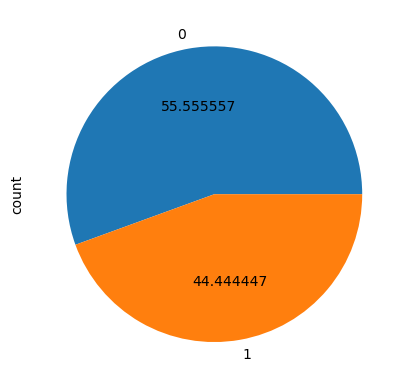

In [243]:
df['Heart Disease'].value_counts().plot(kind='pie',autopct="%2f") #Finding percentage of people having/not having heart diseases

In [292]:
#not imbalanced

<Axes: xlabel='Cholesterol'>

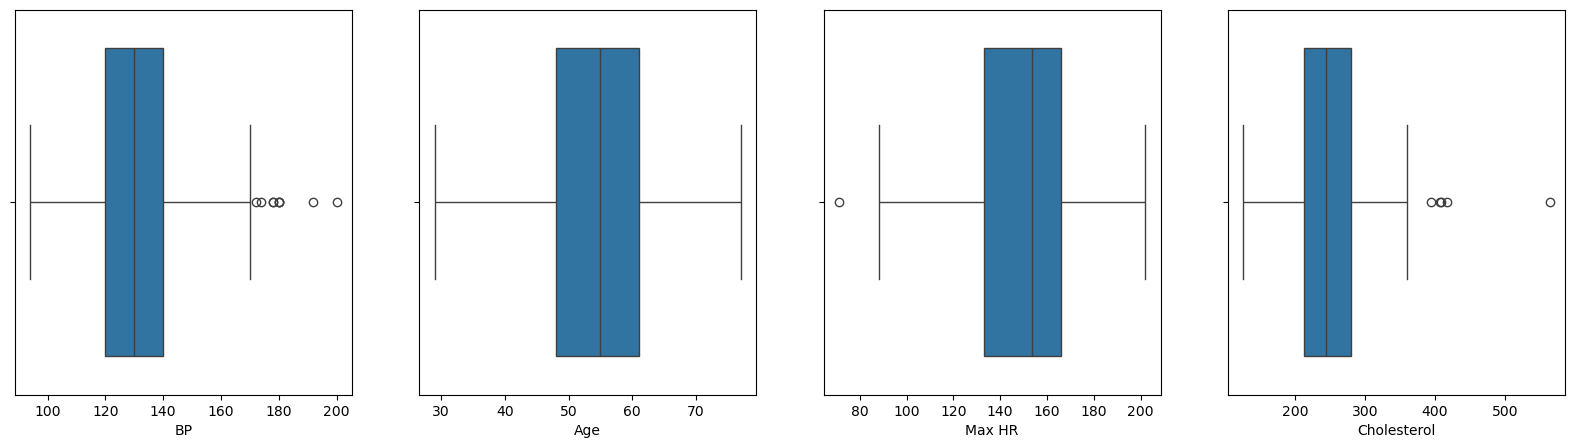

In [244]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.boxplot(x=df['BP']) #boxplots for outlier detection
plt.subplot(1,4,2)
sns.boxplot(x=df["Age"])
plt.subplot(1,4,3)
sns.boxplot(x=df['Max HR'])
plt.subplot(1,4,4)
sns.boxplot(x=df['Cholesterol'])


In [245]:
#There are outliers, need to delete 




<H2>Multivariate Analysis</H2>

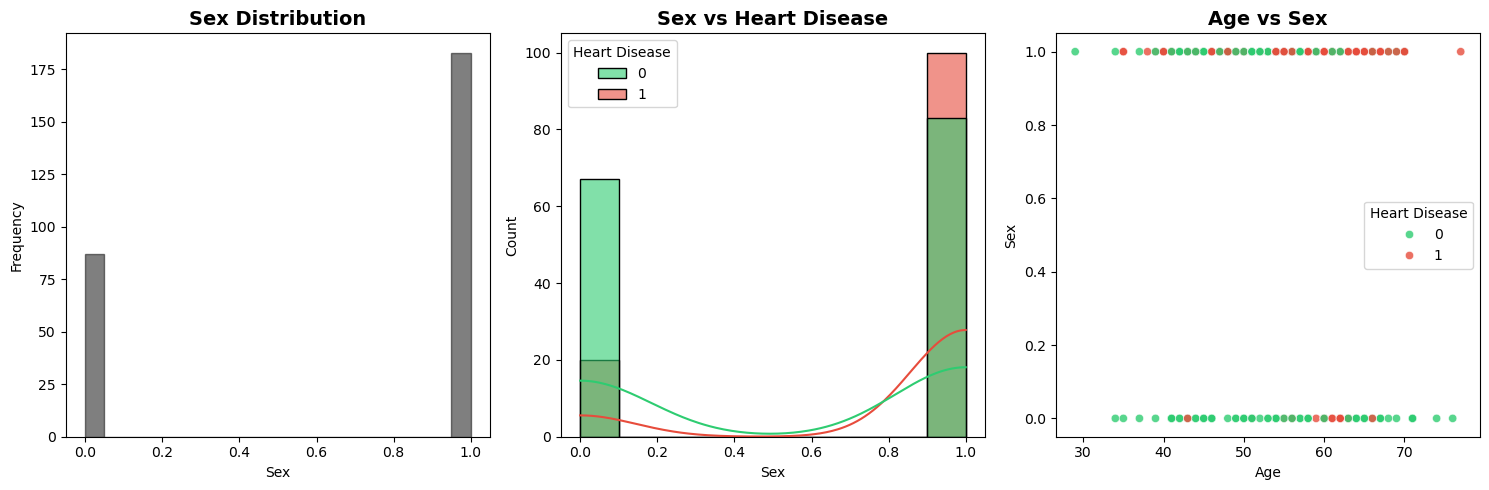

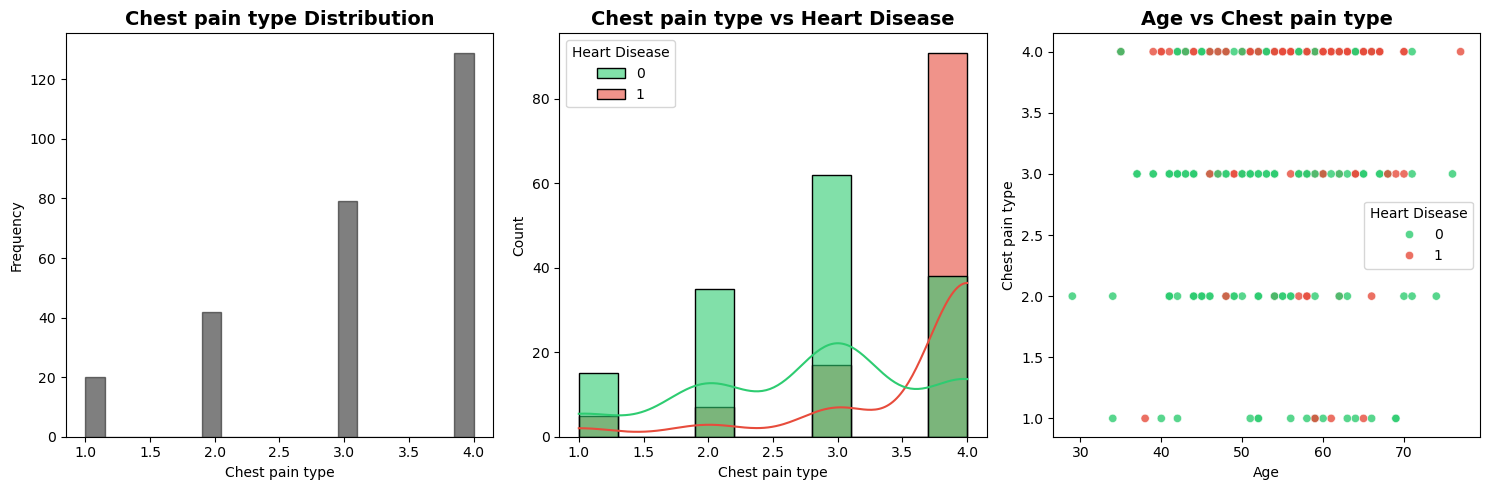

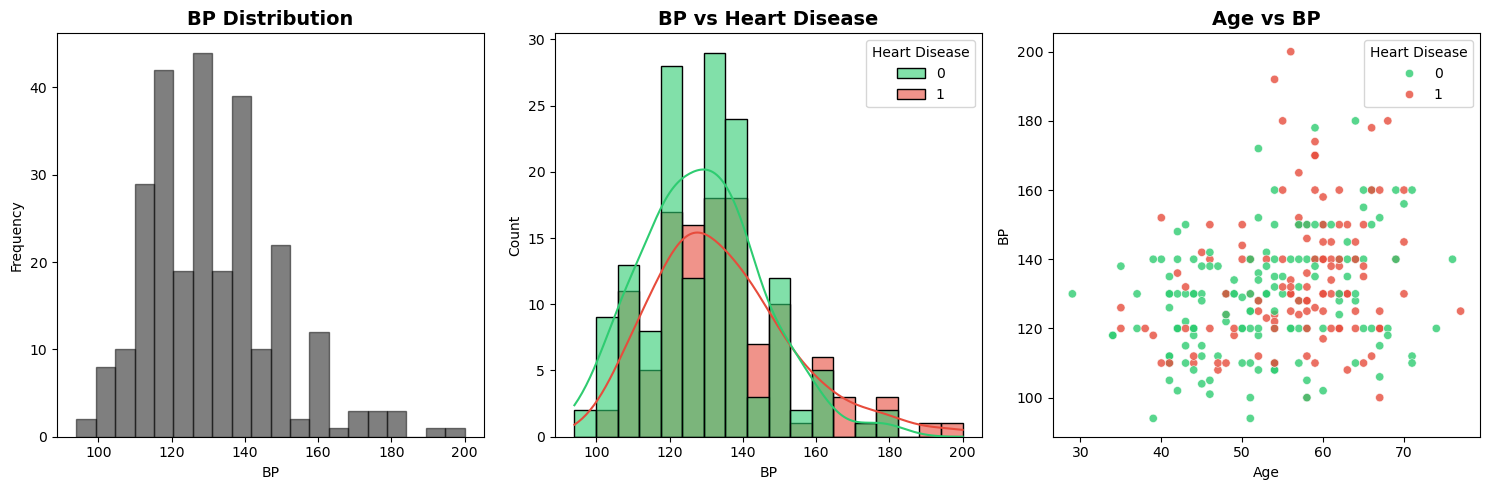

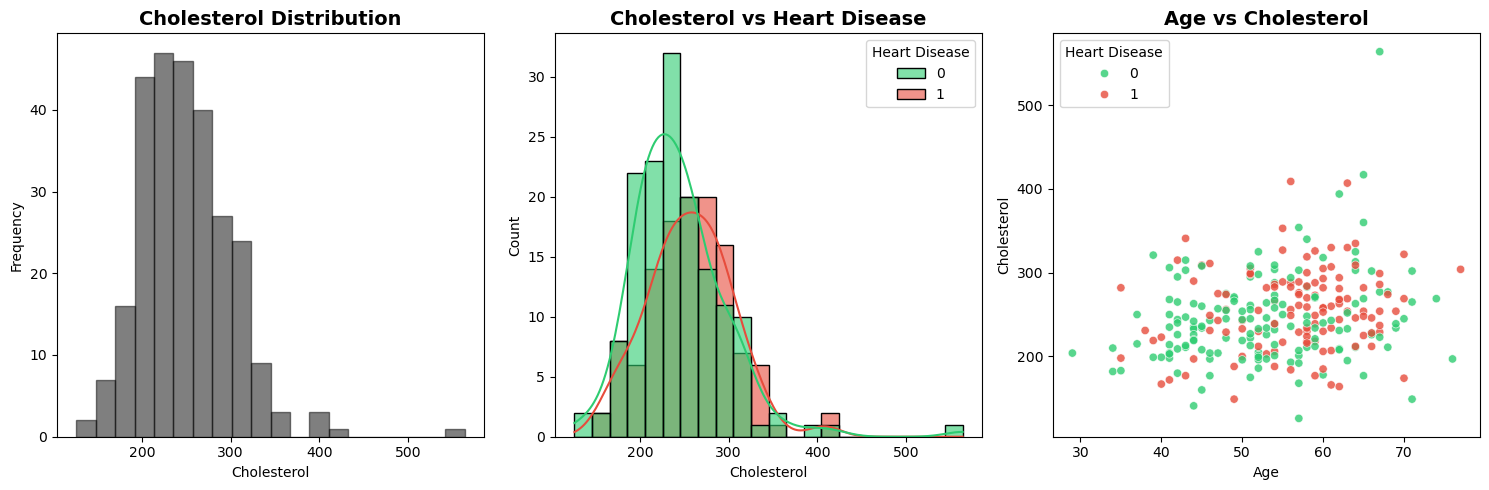

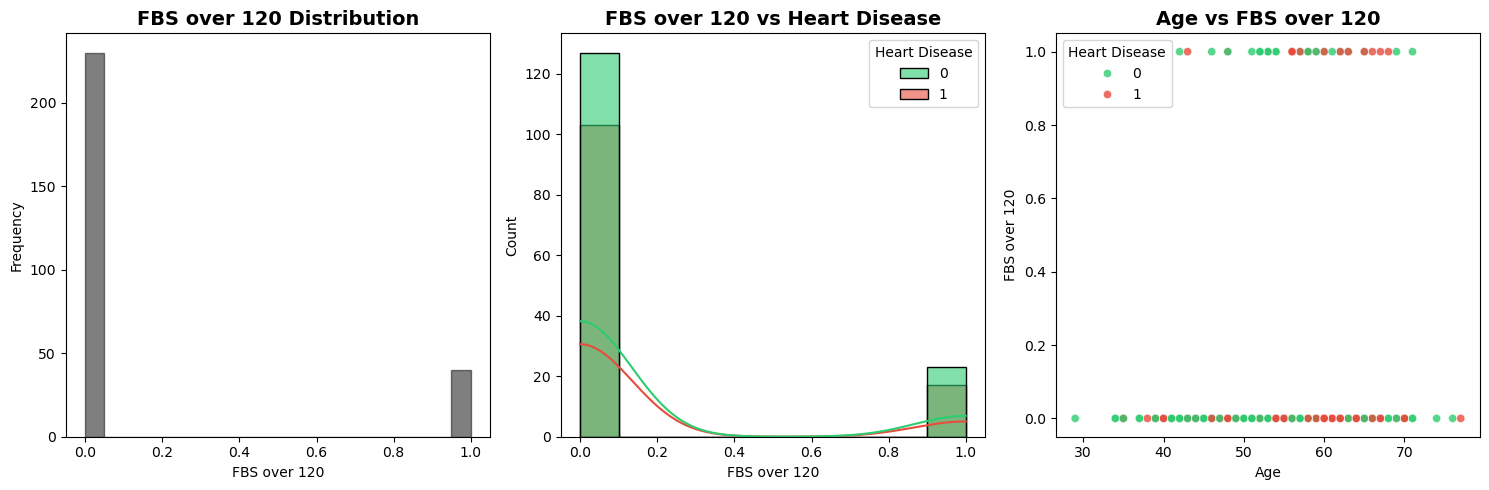

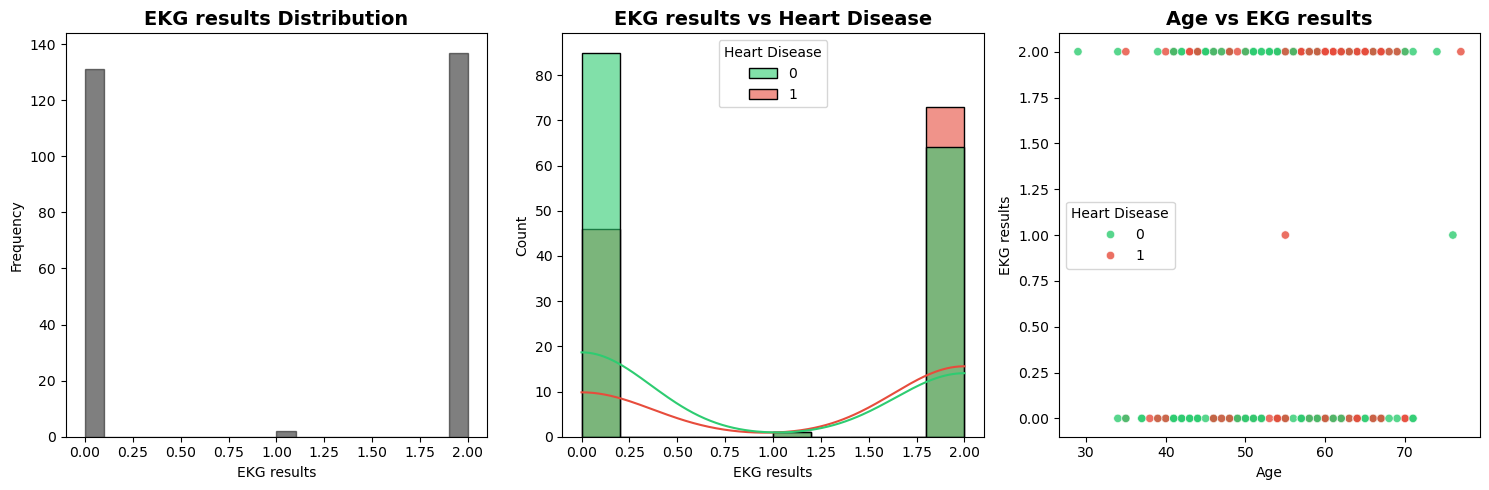

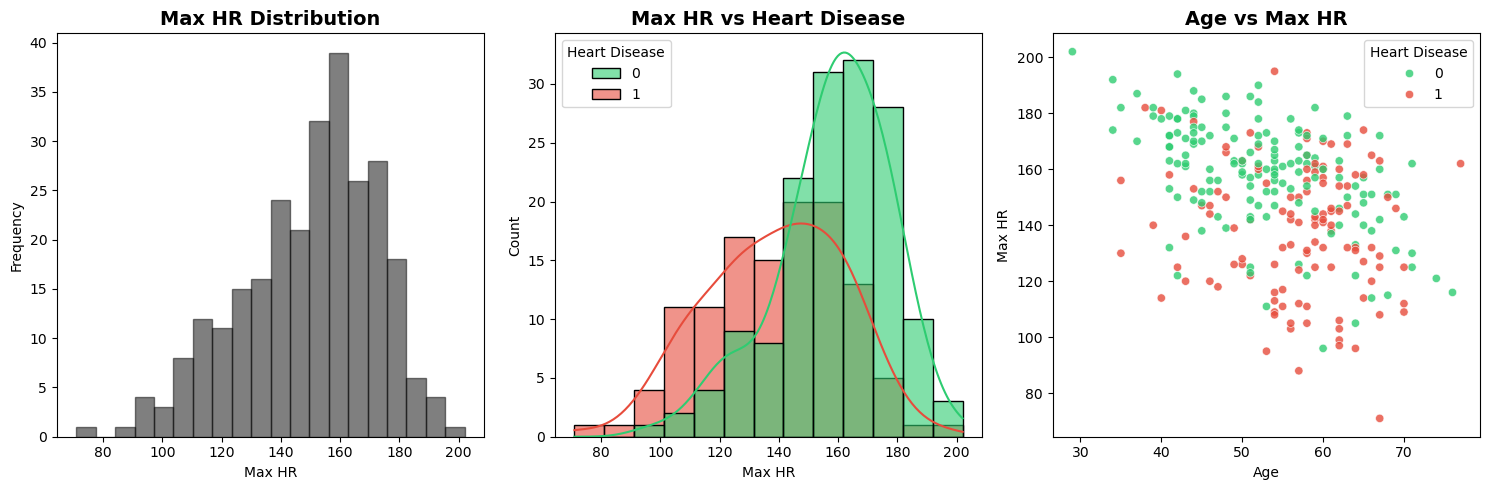

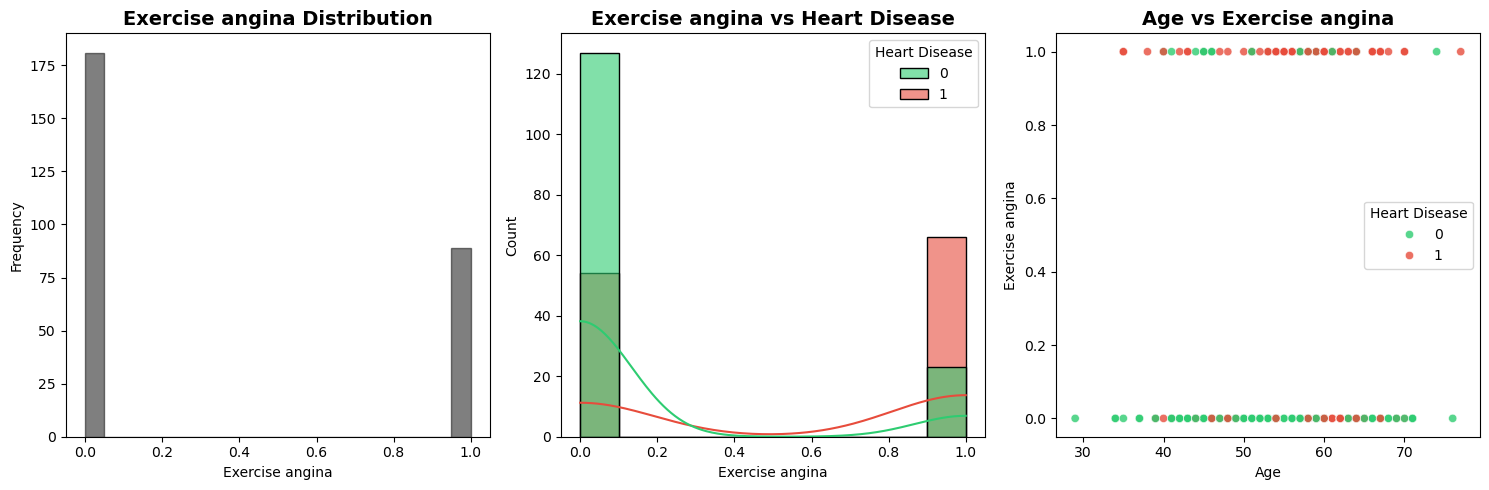

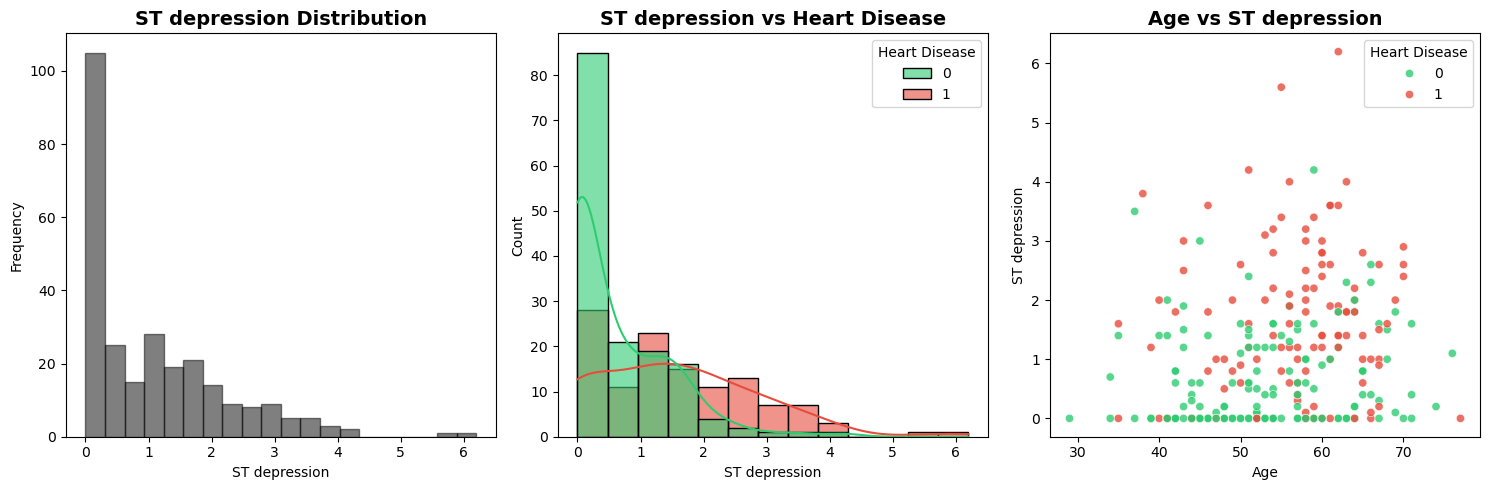

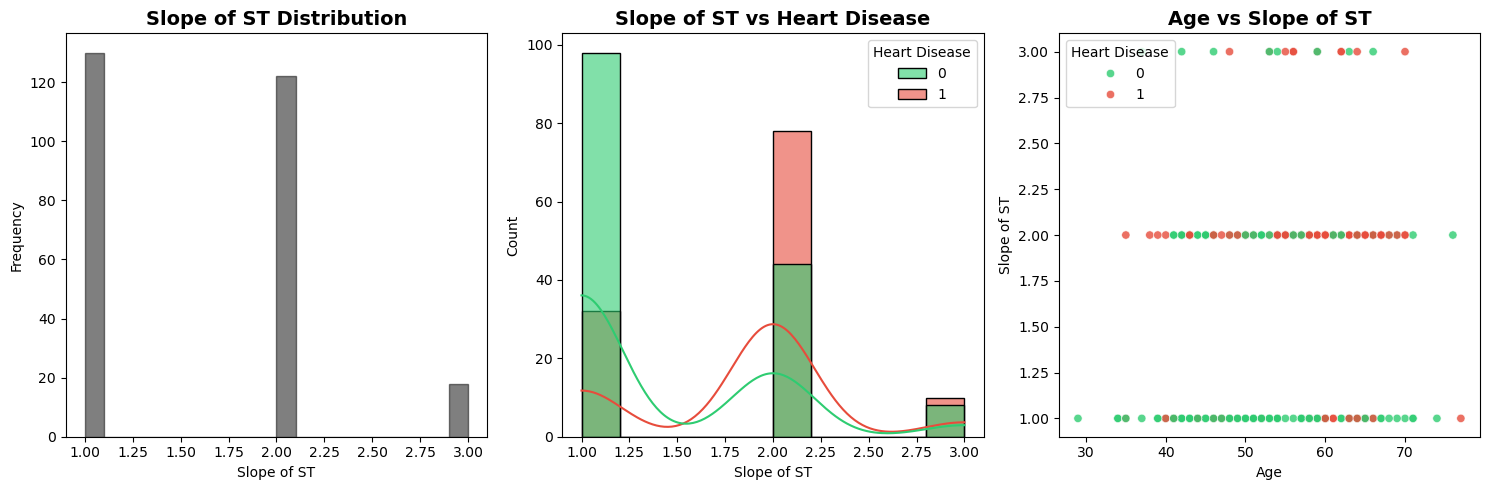

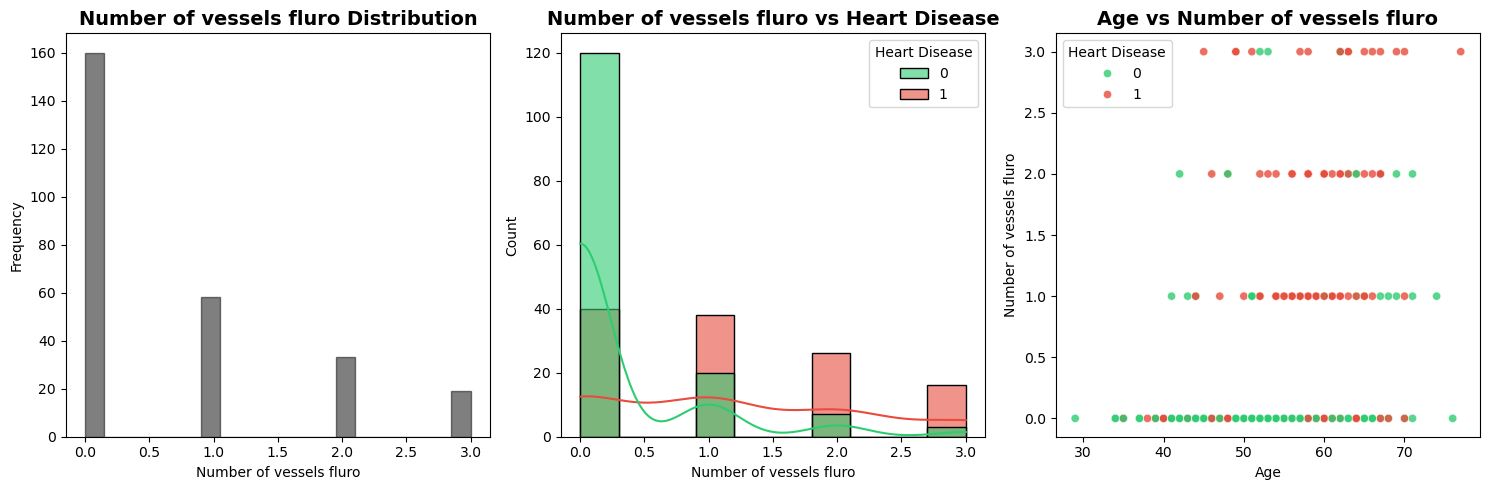

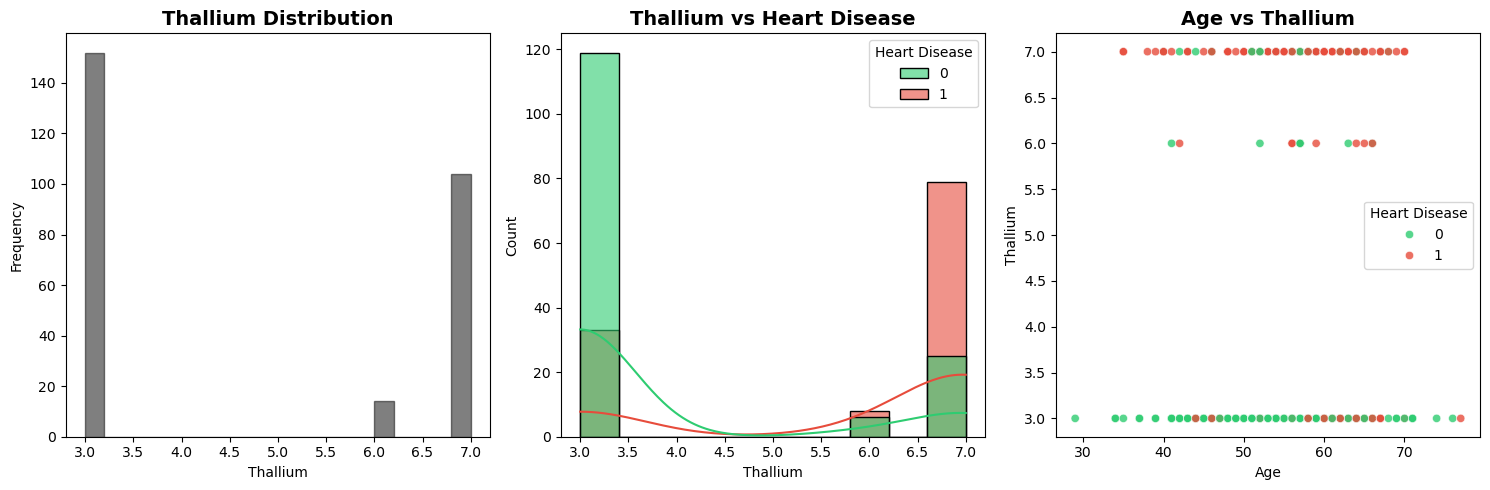

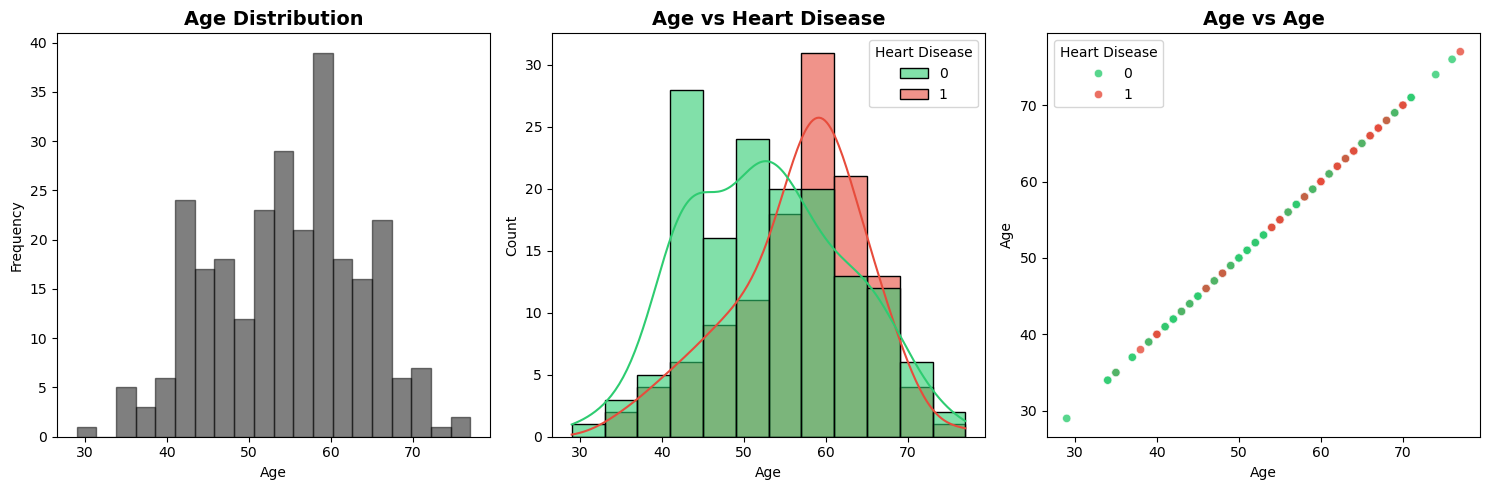

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 
            'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 
            'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Age']

for feature in features:
    plt.figure(figsize=(15, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(df[feature], bins=20, color='black', edgecolor='black', alpha=0.5)
    plt.title(f'{feature} Distribution', fontsize=14, fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.histplot(data=df, x=feature, hue='Heart Disease', 
                 palette=['#2ecc71', '#e74c3c'], alpha=0.6, kde=True)
    plt.title(f'{feature} vs Heart Disease', fontsize=14, fontweight='bold')
    
    # Scatterplot 
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=df, x='Age', y=feature, hue='Heart Disease', 
                    palette=['#2ecc71', '#e74c3c'], alpha=0.8)
    plt.title(f'Age vs {feature}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [247]:
#Important features identified- chest pain type, bp, cholestorol, max HR, angina, Ischemia, Number of vessel fluro, Thallium, Age


<H2> Feature Engineering </H2>

In [248]:
def ischemia_risk(row):
    if row["ST depression"] >= 2.0 and row["Slope of ST"] == 3:
        return "high"                                           #Engineering a new feature called ischemia_risk by combining ST depression and slope of ST
    elif row["ST depression"] >= 1.0:
        return "moderate"
    else:
        return "low"

df["ischemia_risk"] = df.apply(ischemia_risk, axis=1)


In [249]:
df = pd.get_dummies(df, columns=["ischemia_risk"], drop_first=False)
df["ischemia_risk_low"] = df["ischemia_risk_low"].astype(int)
df["ischemia_risk_moderate"] = df["ischemia_risk_moderate"].astype(int) #one hot encoding the ischemia risks 


In [250]:
df = df.drop(["ischemia_risk_high", "EKG results", "FBS over 120"], axis=1) #Dropping less important features

In [251]:
df = df.drop(["ST depression", "Slope of ST"], axis=1) #dropping features which are already combined into another

In [252]:
#train-test split before scaling

from sklearn.model_selection import train_test_split 

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True )

#splitting target from training
X_train = df_train.drop(columns=["Heart Disease"])
y_train = df_train["Heart Disease"]

X_test = df_test.drop(columns=["Heart Disease"])
y_test = df_test["Heart Disease"]


In [253]:
X_test.sample(5)

,Age,Sex,Chest pain type,BP,Cholesterol,Max HR,Exercise angina,Number of vessels fluro,Thallium,ischemia_risk_low,ischemia_risk_moderate
144,54,1,2,192,283,195,0,1,7,1,0
158,56,1,1,120,193,162,0,0,7,0,1
194,48,1,3,124,255,175,0,2,3,1,0
68,44,0,3,118,242,149,0,1,3,1,0
82,58,1,4,150,270,111,1,0,7,1,0



<H2>Model Implementation</H2>


In [283]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression         #Binary classifier problem so choosing Logistic Regression
from sklearn.compose import ColumnTransformer

# Columns with outliers
outlier_cols = ["Cholesterol", "BP", "Max HR"]
normal_cols = [c for c in X_train.columns if c not in outlier_cols]

# Preprocessing: Robust scaling for outliers, standard scaling for others
preprocessor = ColumnTransformer([
    ("robust", RobustScaler(), outlier_cols),
    ("standard", StandardScaler(), normal_cols)
])

reg = Pipeline([
    ("preprocess", preprocessor),         #using Elasticnet as dataset is less than 50k samples, but not extremely small. 
    ("model", LogisticRegression(
        penalty="elasticnet",
        solver="saga",     
        l1_ratio=0.7,        
        C=10,               
        max_iter=5000,
        random_state=42
    ))
])


# Train
reg.fit(X_train, y_train)

# Predict
y_pred_lr = reg.predict(X_test)
y_prob_lr = reg.predict_proba(X_test)[:, 1]



In [284]:
#will check here if robust scaling actually worked in reducing the outliers
# Get fitted preprocessor
preprocessor_fitted = reg.named_steps["preprocess"]

# Transform training data
X_train_transformed = preprocessor_fitted.transform(X_train)

# Get column order after ColumnTransformer
robust_features = outlier_cols
standard_features = normal_cols
all_features = robust_features + standard_features

X_train_scaled = pd.DataFrame(
    X_train_transformed,
    columns=all_features,
    index=X_train.index
)


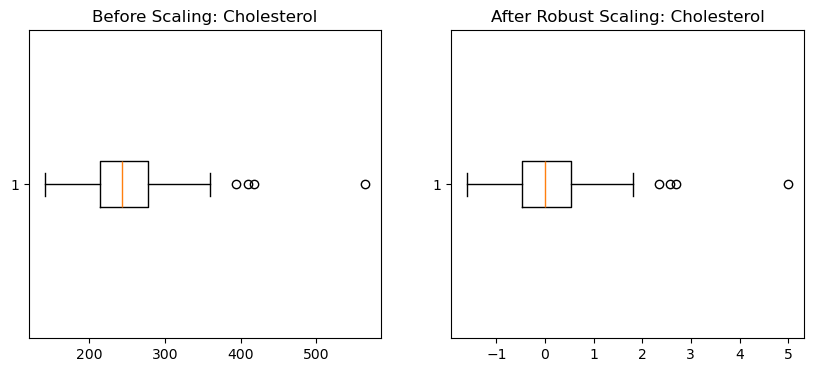

In [285]:
feature = "Cholesterol"

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before scaling
axes[0].boxplot(X_train[feature], vert=False)
axes[0].set_title(f"Before Scaling: {feature}")

# After Robust Scaling
axes[1].boxplot(X_train_scaled[feature], vert=False)
axes[1].set_title(f"After Robust Scaling: {feature}")

plt.show()


<H2>Performance Metrics</H2>

In [286]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n{name}")
    print("-" * len(name))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))


In [287]:
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.4f}")
recall = recall_score(y_test, y_pred_lr)
print(f"Recall:{recall:.4f}")



Logistic Regression
-------------------
Confusion Matrix:
[[32  1]
 [ 5 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        33
           1       0.94      0.76      0.84        21

    accuracy                           0.89        54
   macro avg       0.90      0.87      0.88        54
weighted avg       0.89      0.89      0.89        54

ROC-AUC: 0.9552669552669553
Accuracy: 0.8889
Recall:0.7619


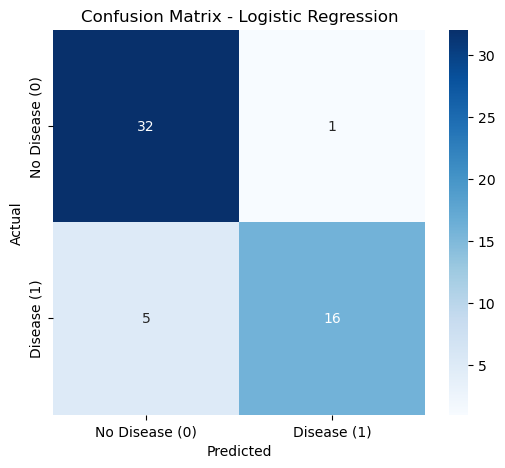

In [288]:
#confusion matrix
cmlr = [[32, 1],
      [5, 16]]

labels = ['No Disease (0)', 'Disease (1)']

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(cmlr, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [289]:
#Note:Need to improve the recall as it's a medical case and False Negative must me minimized. Can do thresholding